#### Import Libraries

In [1]:
import os
import json
import re
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from openai import OpenAI

#### Setup OpenAI client

In [2]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

#### Load & Clean data

In [3]:
df = pd.read_csv(
    "../data/market_basket_dataset.csv",
    delimiter=";",
    decimal=",",
    encoding="utf-8",
    low_memory=False
)
df = df[df["Quantity"] > 0].dropna(subset=["Itemname","BillNo"])
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#### Visualize Dataset

In [4]:
# Helper to style axes
def style_axes(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()

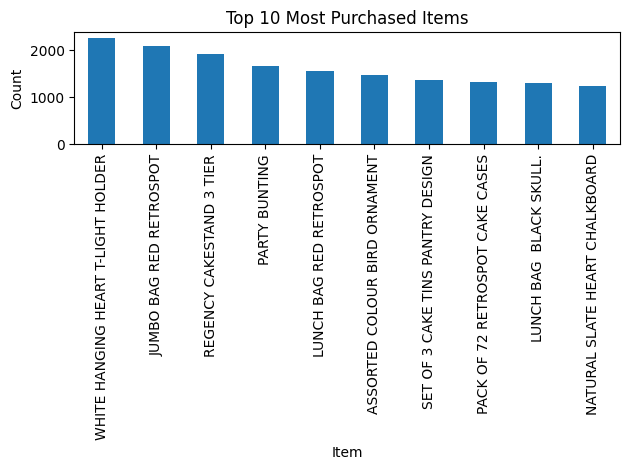

In [5]:
# 1. Top 10 Most Purchased Items
fig, ax = plt.subplots()
df['Itemname'].value_counts().head(10).plot.bar(ax=ax)
style_axes(ax, 'Item', 'Count', 'Top 10 Most Purchased Items')

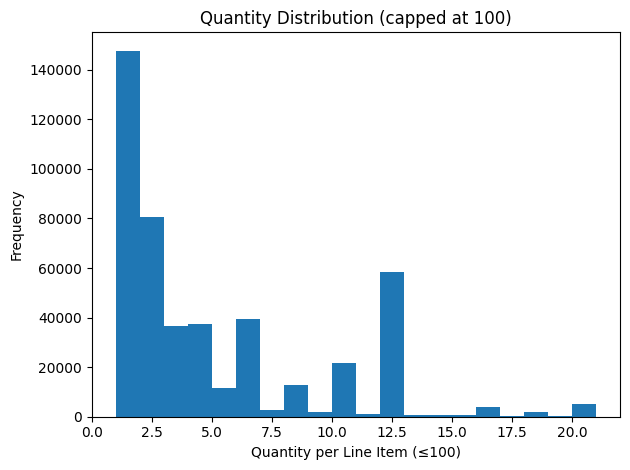

In [6]:
# 2. Quantity Distribution
fig, ax = plt.subplots()

# Focus histogram on quantities <=100 for clarity
quant_limited = df.loc[df['Quantity'] <= 100, 'Quantity']
bins = range(1, 22)
quant_limited.plot.hist(bins=bins, ax=ax)
style_axes(ax, 'Quantity per Line Item (≤100)', 'Frequency', 'Quantity Distribution (capped at 100)')

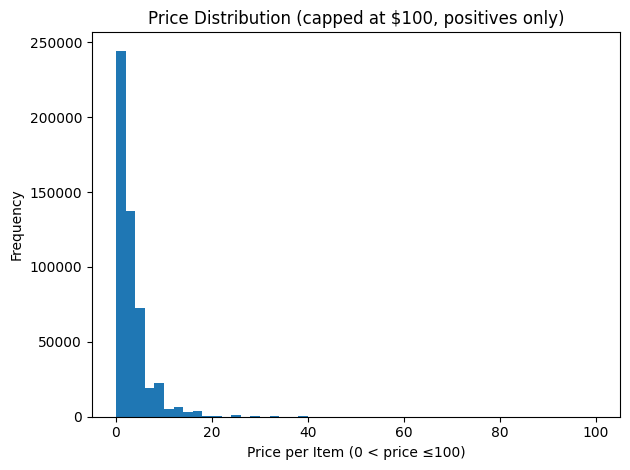

In [7]:
# 3. Price Distribution
fig, ax = plt.subplots()
price_limited = df[(df['Price'] > 0) & (df['Price'] <= 100)]['Price']
price_limited.plot.hist(bins=50, ax=ax)
style_axes(ax, 'Price per Item (0 < price ≤100)', 'Frequency', 'Price Distribution (capped at $100, positives only)')

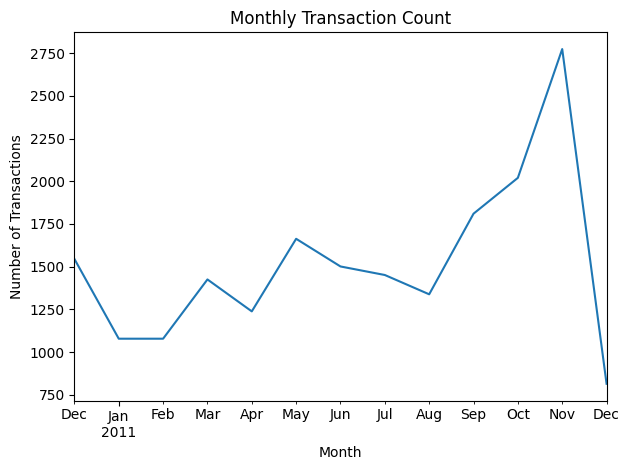

In [8]:
# 4. Monthly Transaction Count
fig, ax = plt.subplots()
monthly_txns = (
    df.groupby(df['Date'].dt.to_period('M'))['BillNo']
      .nunique()
      .to_timestamp()
)
monthly_txns.plot(ax=ax)
style_axes(ax, 'Month', 'Number of Transactions', 'Monthly Transaction Count')

In [9]:
plt.show()

#### Run Apriori & pick top 10 rules

In [10]:
transactions = df.groupby("BillNo")["Itemname"].apply(list).tolist()

In [11]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

df_encoded.head(2)

,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules = rules[rules["confidence"] > 0.3]
top_rules = rules.sort_values("lift", ascending=False).head(10)
top_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
2077,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010641,0.011806,0.010134,0.952381,80.666258,1.0,0.010009,20.752065,0.998225,0.823045,0.951812,0.905375
2080,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011806,0.010641,0.010134,0.858369,80.666258,1.0,0.010009,6.985474,0.999403,0.823045,0.856846,0.905375
2079,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011857,0.010641,0.010134,0.854701,80.321530,1.0,0.010008,6.809118,0.999400,0.819672,0.853138,0.903541
2078,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010641,0.011857,0.010134,0.952381,80.321530,1.0,0.010008,20.751001,0.998172,0.819672,0.951810,0.903541
535,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011806,0.011857,0.010996,0.931330,78.546183,1.0,0.010856,14.389831,0.999064,0.868000,0.930506,0.929340
534,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011857,0.011806,0.010996,0.927350,78.546183,1.0,0.010856,13.602194,0.999115,0.868000,0.926482,0.929340
2076,"(HERB MARKER ROSEMARY, HERB MARKER THYME)",(HERB MARKER PARSLEY),0.010996,0.011756,0.010134,0.921659,78.400604,1.0,0.010005,12.614647,0.998221,0.803213,0.920727,0.891864
2081,(HERB MARKER PARSLEY),"(HERB MARKER ROSEMARY, HERB MARKER THYME)",0.011756,0.010996,0.010134,0.862069,78.400604,1.0,0.010005,7.170281,0.998989,0.803213,0.860535,0.891864
533,(HERB MARKER PARSLEY),(HERB MARKER THYME),0.011756,0.011806,0.010641,0.905172,76.667715,1.0,0.010502,10.420950,0.998697,0.823529,0.904039,0.903230
532,(HERB MARKER THYME),(HERB MARKER PARSLEY),0.011806,0.011756,0.010641,0.901288,76.667715,1.0,0.010502,10.011344,0.998748,0.823529,0.900113,0.903230


#### Build rules_list and compute bundle pricing

In [13]:
# Avg price per item
price_map = df.groupby("Itemname")["Price"].mean().to_dict()
discount_rate = 0.15  # 15%

rules_list = []
for _, row in top_rules.iterrows():
    ants = list(row["antecedents"])
    cons = list(row["consequents"])
    items = ants + cons
    raw = sum(price_map.get(item, 0) for item in items)
    bundle = round(raw * (1 - discount_rate), 2)
    rules_list.append({
        "antecedents": ants,
        "consequents": cons,
        "support": float(row["support"]),
        "confidence": float(row["confidence"]),
        "lift": float(row["lift"]),
        "raw_bundle_price": round(raw, 2),
        "suggested_bundle_price": bundle
    })

#### Open AI Interaction

In [14]:
# Prepare prompt
data_json = json.dumps(rules_list, ensure_ascii=False)
prompt = f"""
You are a retail strategist. I have a JSON array `rules_list` where each object has:
- antecedents, consequents, support, confidence, lift,
- raw_bundle_price (sum of avg prices),
- suggested_bundle_price (15% off).

For each rule, return ONE object with:
- antecedents (list of strings)
- consequents (list of strings)
- bundle_price (the suggested_bundle_price)
- insight (one-sentence marketing copy that mentions the bundle_price)

Return only a single valid JSON array—no markdown or extra text.

Data = {data_json}
"""

In [15]:
# Call GPT
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a helpful retail marketing assistant."},
        {"role": "user",   "content": prompt}
    ],
    temperature=0.7
)

In [16]:
# Extract & clean JSON
raw = response.choices[0].message.content
clean = re.sub(r"^```json\s*|\s*```$", "", raw, flags=re.MULTILINE).strip()
insights = json.loads(clean)

#### Format Output

In [17]:
# Convert to DataFrame, rename, sanitize & display
df_insights = pd.DataFrame(insights)

# Flatten and rename columns for business users
df_insights["Items Bought"]   = df_insights["antecedents"].apply(lambda lst: ", ".join(lst))
df_insights["Also Bought"]    = df_insights["consequents"].apply(lambda lst: ", ".join(lst))
df_insights["Bundle Price"]   = df_insights["bundle_price"].apply(lambda p: f"${p:.2f}")
df_insights["Recommendation"] = df_insights["insight"]

# Remove any stray newlines or pipes inside text
for col in ["Items Bought", "Also Bought", "Recommendation"]:
    df_insights[col] = (
        df_insights[col]
        .str.replace("\n", " ", regex=False)
        .str.replace("|", "/", regex=False)
    )

# Select and order
df_out = df_insights[["Items Bought", "Also Bought", "Bundle Price", "Recommendation"]]

# Print a clean GitHub‑flavored Markdown table
print(df_out.to_markdown(index=False, tablefmt="github"))

| Items Bought                              | Also Bought                               | Bundle Price   | Recommendation                                                                            |
|-------------------------------------------|-------------------------------------------|----------------|-------------------------------------------------------------------------------------------|
| HERB MARKER ROSEMARY, HERB MARKER PARSLEY | HERB MARKER THYME                         | $2.17          | Create a perfect herb trio with Rosemary and Parsley markers for only $2.17!              |
| HERB MARKER THYME                         | HERB MARKER ROSEMARY, HERB MARKER PARSLEY | $2.17          | Complete your herb collection with Thyme and enjoy a discount at $2.17!                   |
| HERB MARKER ROSEMARY                      | HERB MARKER THYME, HERB MARKER PARSLEY    | $2.17          | Enhance your garden with Rosemary markers and get Thyme and Parsley for just $2.17!       |
| HER

#### Save Output

In [18]:
# Save outputs
os.makedirs("../output", exist_ok=True)
with open("../output/bundle_insights.json","w") as f:
    json.dump(insights, f, indent=2)
with open("../output/bundle_insights.md","w") as f:
    f.write("# Bundle Insights\n\n")
    f.write(df_out.to_markdown(index=False))

print("\n✅ Completed. JSON → output/bundle_insights.json, Markdown → output/bundle_insights.md")


✅ Completed. JSON → output/bundle_insights.json, Markdown → output/bundle_insights.md
